In [1]:
import librosa

test_path = '/media/yoonseok/Data/Corpus/Audio/korean_reading/audio/fv01/fv01_t01_s02.wav'
test_label_path = '/media/yoonseok/Data/Corpus/Audio/korean_reading/label/fv01_t01_s02.textgrid'
raw, sr = librosa.load(test_path, sr=16000)

In [2]:
import IPython.display as ipd
# ipd.Audio(raw, rate=sr) # load a NumPy array


In [3]:
from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output

import librosa.display
import matplotlib.pyplot as plt

def make_ui( sub_name):
    def wrapper1(func):
        def wrapper(*args, **kwargs):

            result = func(*args, **kwargs)

            print(result.file_name)
            draw_wav_form(result.org_raw, sr, 'org wav')
            draw_wav_form(result.raw, sr, 'noise wav')

            button = widgets.Button(
                description='Save',disabled=False, button_style='success', tooltip='Click me', icon='check')

            def button_clicked(sender):
                result.save(sub_name)
    #             clear_output()

    #         def next_button_clicked(sender):
    #             clear_output()

            button.on_click(button_clicked)
            display(button)

    #         next_button.on_click(next_button_clicked)
    #         display(next_button)
            return result
        return wrapper
    return wrapper1

def draw_wav_form(raw, sr, title = 'WAV wave form'):
    plt.figure()
    plt.subplot(3, 1, 1)
    librosa.display.waveplot(raw, sr=sr)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [4]:
import numpy as np
import textgrid
import os

import random

class NoiseMaker(object):
    def __init__(self, test_path, test_label_path):
        self.raw, self.sr = librosa.load(test_path, sr=16000)
        self.org_raw = self.raw.copy()
        self.file_name = os.path.basename(test_path)
        self.textgrid_path = test_label_path
        
        self.tgm = self.TextGridManager()
        
    def random_PAU(self, length):
#         minTime, maxTime = self.tgm.get_random_phoneme(self.textgrid_path)
        minTime, maxTime = self.tgm.get_random_phoneme_vowel(self.textgrid_path)
        return self.add_silence(maxTime, length)
    
    def random_PRE(self):
#         minTime, maxTime = self.tgm.get_random_phoneme(self.textgrid_path)
        minTime, maxTime = self.tgm.get_random_phoneme_const(self.textgrid_path)
        return self.add_duplicate(maxTime, minTime, maxTime)
    
    def random_CUT(self):
        minTime, maxTime = self.tgm.get_random_phoneme(self.textgrid_path)
        return self.remove(minTime, maxTime)
    
    def random_EXT(self):
        minTime, maxTime = self.tgm.get_random_phoneme(self.textgrid_path)
        return self.add_expand(minTime, maxTime)
    
    @make_ui(sub_name='silence')
    def add_silence(self, start, length):
#         raw_change = self.raw.copy()
        self.raw = np.insert(self.raw, start, np.zeros(length))
        self.raw.flatten()
        return self
    
    @make_ui(sub_name='dup')
    def add_duplicate(self, insert_start, dup_start, dup_end):
        dup_part = self.raw[dup_start:dup_end]
        self.raw = np.insert(self.raw, insert_start, dup_part)
        return self
    
    def add_dissolve(self, start, end):
        length = end - start
        self.raw[start:end] = np.multiply(self.raw[start:end], np.linspace(1.0, 0.0, num=length))
        return self
        
    @make_ui(sub_name='remove')
    def remove(self, start, end):
        length = end - start
        self.raw[start:end] = np.zeros(length)
        return self
    
    @make_ui(sub_name='expand')
    def add_expand(self, start, end):
        temp_slice = self.raw[start:end].copy()
#         resample = self.slow(temp_slice, 16000)
        resample = librosa.effects.time_stretch(temp_slice, 0.5)
        
        temp_raw = np.append(self.raw[:start],resample)
        self.raw = np.append(temp_raw, self.raw[end:])
        
        print(self.raw.shape)
#         self.raw = self.slow(self.raw, 16000)
        return self
    
    def slow(self, y, sr):
        D = librosa.stft(y, n_fft=2048, hop_length=512)
        D_slow = librosa.phase_vocoder(D, 1. / 2, hop_length=512)
        y_slow = librosa.istft(D_slow, hop_length=512)
        np.resize(y_slow, [1, sr])
        return y_slow
    
    def save(self, sub_name = 'mis'):
        path = '/media/yoonseok/Data/Corpus/Audio/miscue'
        save_path = os.path.join(path, sub_name + self.file_name)
        librosa.output.write_wav(save_path, self.raw, self.sr)
        
    class TextGridManager(object):
        def __init__(self):
            self.vowel_list = ['IY', 'EH', 'EY', 'AA', 'WW', 'UW', 'OW', 'AX', 'JH', 'JE', 'JA', 'JO', 'JU', 'JX', 'UI',
                               'WH', 'WE', 'OI', 'WA', 'WX', 'WI']
               
        def get_random_phoneme(self, path):
            tg = textgrid.TextGrid()
            tg.read(path)
            phones1 = tg.tiers[1]
    #         print(phone[0])
            phone = random.choice(phones1)
    #         print(phone.maxTime)
            return int(librosa.core.time_to_samples(phone.minTime, sr=16000)), int(librosa.core.time_to_samples(phone.maxTime, sr=16000))
    
    
        def get_random_phoneme_vowel(self, path):
            tg = textgrid.TextGrid()
            tg.read(path)

            phones1 = tg.tiers[1]
            while True:
                phone = random.choice(phones1)
                if phone.mark in self.vowel_list:
                    min_time = int(librosa.core.time_to_samples(phone.minTime, sr=16000))
                    max_time = int(librosa.core.time_to_samples(phone.maxTime, sr=16000))
                    return min_time, max_time
                
        def get_random_phoneme_const(self, path):
            tg = textgrid.TextGrid()
            tg.read(path)

            phones1 = tg.tiers[1]
            while True:
                phone = random.choice(phones1)
                if not phone.mark in self.vowel_list:
                    print(phone.mark)
                    min_time = int(librosa.core.time_to_samples(phone.minTime, sr=16000))
                    max_time = int(librosa.core.time_to_samples(phone.maxTime, sr=16000))
                    return min_time, max_time

### Silence 추가하기 (PAU)

fv01_t01_s02.wav


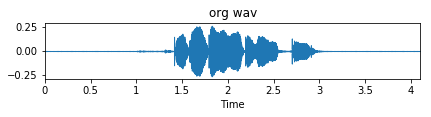

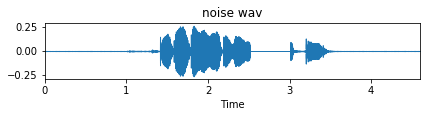

A Jupyter Widget

In [47]:
nm_pau = NoiseMaker(test_path, test_label_path)
# play_raw = nm_pau.add_silence(50000, 16000).raw
play_raw = nm_pau.random_PAU(8000).raw
ipd.Audio(play_raw, rate=sr)

### 중복구간 추가하기 (PRE)

TQ
fv01_t01_s02.wav


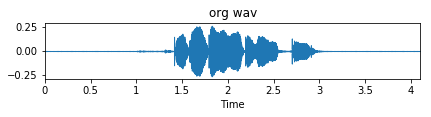

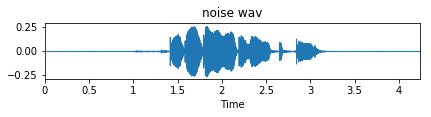

A Jupyter Widget

In [50]:
nm_pre = NoiseMaker(test_path, test_label_path)
# play_raw = nm_pre.add_duplicate(70000, 50000, 60000).raw
play_raw = nm_pre.random_PRE().raw
ipd.Audio(play_raw, rate=sr)

### 소리 작아지게 만들기

In [ ]:
nm = NoiseMaker(test_path)
play_raw = nm.add_dissolve(40000, 60000).raw
ipd.Audio(play_raw, rate=sr)

### 중간 부분 삭제 (CUT)

fv01_t01_s02.wav


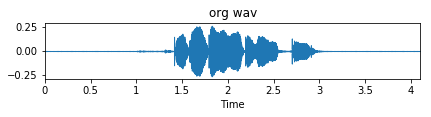

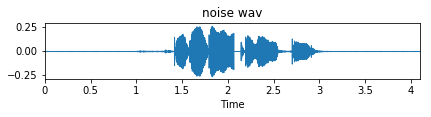

A Jupyter Widget

In [39]:
nm_cut = NoiseMaker(test_path, test_label_path)
# play_raw = nm_cut.remove(40000,45000).raw
play_raw = nm_cut.random_CUT().raw
ipd.Audio(play_raw, rate=sr)

### 중간부분 늘리기 (EXT)

(68077,)
fv01_t01_s02.wav


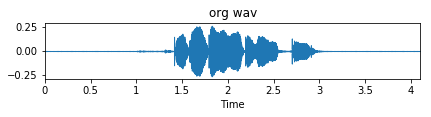

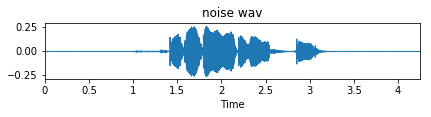

A Jupyter Widget

In [30]:
nm_ext = NoiseMaker(test_path, test_label_path)
# play_raw = nm_ext.add_expand(25000,50000).raw
play_raw = nm_ext.random_EXT().raw
ipd.Audio(play_raw, rate=sr)

In [ ]:
ls /media/yoonseok/Data/Corpus/Audio/korean_reading/

In [ ]:
ls /home/yoonseok/다운로드/s60k001_sm_2_00001.textgrid

In [ ]:
ls /media/yoonseok/Data/Corpus/Audio/KMCorpus/label/

## 파일 변경하기
* audio file directory : ```/media/yoonseok/Data/Corpus/Audio/korean_reading/audio/```
* label file directory : ```/media/yoonseok/Data/Corpus/Audio/korean_reading/label/```
* miscue file directory (out) : ```/media/yoonseok/Data/Corpus/Audio/KMCorpus/miscue/```

In [12]:
ls /media/yoonseok/Data/Corpus/Audio/korean_reading/align/20남녀-1/output/textgrid/

fv01_t01_s01.textgrid*  fv04_t05_s42.textgrid*  fv07_t10_s36.textgrid*
fv01_t01_s02.textgrid*  fv04_t05_s43.textgrid*  fv07_t10_s37.textgrid*
fv01_t01_s03.textgrid*  fv04_t05_s44.textgrid*  fv07_t10_s38.textgrid*
fv01_t01_s04.textgrid*  fv04_t05_s45.textgrid*  fv07_t10_s39.textgrid*
fv01_t01_s05.textgrid*  fv04_t05_s46.textgrid*  fv07_t10_s40.textgrid*
fv01_t01_s06.textgrid*  fv04_t05_s47.textgrid*  fv07_t10_s41.textgrid*
fv01_t01_s07.textgrid*  fv04_t06_s01.textgrid*  fv07_t10_s42.textgrid*
fv01_t01_s08.textgrid*  fv04_t06_s02.textgrid*  fv07_t10_s43.textgrid*
fv01_t01_s09.textgrid*  fv04_t06_s03.textgrid*  fv07_t10_s44.textgrid*
fv01_t01_s10.textgrid*  fv04_t06_s04.textgrid*  fv07_t10_s45.textgrid*
fv01_t01_s11.textgrid*  fv04_t06_s05.textgrid*  fv07_t10_s46.textgrid*
fv01_t01_s12.textgrid*  fv04_t06_s06.textgrid*  fv07_t10_s47.textgrid*
fv01_t01_s13.textgrid*  fv04_t06_s07.textgrid*  fv07_t10_s48.textgrid*
fv01_t01_s14.textgrid*  fv04_t06_s08.textgrid*  fv07_t10_s49.textgrid*
fv01_t

In [38]:
import os
import collections

corpus_path = '/media/yoonseok/Data/Corpus/Audio/korean_reading/'

corpus_audio_path = os.path.join(corpus_path, 'audio')
wav_list = find_subfiles(corpus_audio_path, '.wav')

corpus_label_path = os.path.join(corpus_path, 'label')
label_list = find_subfiles(corpus_label_path, '.textgrid')
# label_list = os.listdir(corpus_label_path)



In [43]:
textgrid_list = [label.split('/')[-1] for label in label_list]
textgrid_list

['fv01_t01_s01.textgrid',
 'fv01_t01_s02.textgrid',
 'fv01_t01_s03.textgrid',
 'fv01_t01_s04.textgrid',
 'fv01_t01_s05.textgrid',
 'fv01_t01_s06.textgrid',
 'fv01_t01_s07.textgrid',
 'fv01_t01_s08.textgrid',
 'fv01_t01_s09.textgrid',
 'fv01_t01_s10.textgrid',
 'fv01_t01_s11.textgrid',
 'fv01_t01_s12.textgrid',
 'fv01_t01_s13.textgrid',
 'fv01_t01_s14.textgrid',
 'fv01_t01_s15.textgrid',
 'fv01_t01_s16.textgrid',
 'fv01_t01_s18.textgrid',
 'fv01_t01_s19.textgrid',
 'fv01_t01_s20.textgrid',
 'fv01_t01_s21.textgrid',
 'fv01_t01_s22.textgrid',
 'fv01_t01_s23.textgrid',
 'fv01_t01_s24.textgrid',
 'fv01_t01_s25.textgrid',
 'fv01_t01_s26.textgrid',
 'fv01_t01_s27.textgrid',
 'fv01_t01_s28.textgrid',
 'fv01_t01_s29.textgrid',
 'fv01_t01_s30.textgrid',
 'fv01_t01_s31.textgrid',
 'fv01_t01_s32.textgrid',
 'fv01_t01_s33.textgrid',
 'fv01_t01_s35.textgrid',
 'fv01_t01_s36.textgrid',
 'fv01_t01_s37.textgrid',
 'fv01_t01_s38.textgrid',
 'fv01_t01_s39.textgrid',
 'fv01_t01_s40.textgrid',
 'fv01_t01_s

In [44]:
def path_generator(wav_list_):
    for wav_file_name in wav_list:
        label_file_name = wav_file_name.split('/')[-1][:-3]+'textgrid'
#         print(label_file_name, wav_file_name)
        if label_file_name in textgrid_list:
            yield os.path.join(corpus_audio_path, wav_file_name), os.path.join(corpus_label_path, label_file_name)
        
path_gen = path_generator(wav_list)

In [45]:
wav_path, label_path = next(path_gen)
print(wav_path, label_path)

/media/yoonseok/Data/Corpus/Audio/korean_reading/audio/fv01/fv01_t05_s03.wav /media/yoonseok/Data/Corpus/Audio/korean_reading/label/fv01_t05_s03.textgrid


fv01_t05_s03.wav


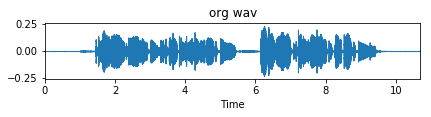

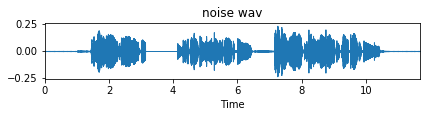

A Jupyter Widget

In [53]:
nm_pau = NoiseMaker(wav_path)
play_raw = nm_pau.add_silence(50000, 16000).raw
ipd.Audio(play_raw, rate=sr)

# def next_source_generator(path_list):
#     for wav_path in wav_list:
#         nm_pau = NoiseMaker(wav_path)
#         play_raw = nm_pau.add_silence(50000, 16000).raw
#         ipd.Audio(play_raw, rate=sr)

In [57]:
import textgrid
import pprint

class TextGridManager(object):
#     def __init__(self):
        
        
    def get_random_phoneme(self, path):
        tg = textgrid.TextGrid()
        tg.read(path)
        phone = tg.tiers.phone1
        print(phone)
        
tgm = TextGridManager().get_random_phoneme()
tg = textgrid.TextGrid()
tg.read(label_path)

for tier in tg.tiers:
    print(tier.name)
#     pprint.pprint(tier)
    print('+'.join([interval.mark for interval in tier]))
#     for interval in tier:
        
#         pprint.pprint(interval.)

word
SILENCE+소설에서는+삶의+모습이+시보다+더+여실하게+드러나기+때문에+우리들의+삶을+그대로+옮긴+것+같은+느낌을+받게+SILENCE
phone1
sil+S+OW+S+AX+R+EY+S+AX+N+WW+NN+S+AA+L+M+WI+M+OW+S+WW+P+IY+S+IY+P+OW+T+AA+T+AX+JX+S+IY+R+AA+K+EY+T+WW+R+AX+N+AA+K+IY+TQ+TT+EH+M+UW+N+EH+UW+R+IY+T+WW+R+WI+S+AA+L+M+WW+L+K+WW+T+EH+R+OW+OW+M+K+IY+NX+K+AX+KQ+K+AA+TQ+TH+WW+NN+N+WW+KK+IY+M+WW+L+P+AA+TQ+KK+EY+T+OI+NN+T+sil
phone2
sil+S+OW+S+AX+R+EY+S+AX+N+WW+NN+S+AA+L+M+WI+M+OW+S+WW+P+IY+S+IY+P+OW+T+AA+T+AX+JX+S+IY+R+AA+K+EY+T+WW+R+AX+N+AA+K+IY+TQ+TT+EH+M+UW+N+EH+UW+R+IY+T+WW+R+WI+S+AA+L+M+WW+L+K+WW+T+EH+R+OW+OW+M+K+IY+NX+K+AX+KQ+K+AA+TQ+TH+WW+NN+N+WW+KK+IY+M+WW+L+P+AA+TQ+KK+EY+T+OI+NN+T+sil


In [4]:
def find_subfiles(path, file_extension):
    name_list = collections.deque()
    for (path, dir_, files) in os.walk(path):
        #         print(len(path))
        #         print(path)
        #         print(dir_)
        sub_folder_name = path.split('/')[-1]
        #         print(sub_folder_name)
        for file_name in files:
            ext = os.path.splitext(file_name)[-1]
            if ext == file_extension:
                file = os.path.join(sub_folder_name, file_name)
                # file = "%s/%s" % (sub_folder_name, file_name)

                name_list.append(file)

    return name_list